## The Premier League's Quarter Backs

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
from highlight_text import fig_text, ax_text
from adjustText import adjust_text
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib import cm
import scipy.stats as stats


from mplsoccer import Pitch

from PIL import Image
import urllib
import os

In [98]:
font_path = "../assets/fonts"
for x in os.listdir(font_path):
    for y in os.listdir(f"{font_path}/{x}"):
        if y.split(".")[-1] == "ttf":
            fm.fontManager.addfont(f"{font_path}/{x}/{y}")
            try:
                fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y.split("-")[0])
            except Exception:
                continue

plt.style.use("../assets/stylesheets/soc_base.mplstyle")
plt.rcParams['font.family'] = 'Karla'

## Data

In [99]:
df = pd.read_csv('data/11072022_long_balls.csv', index_col=0)

In [100]:
df = (
    df.groupby(['player_id', 'player_first_name', 'player_last_name'])
    [['minutes', 'long_balls_att', 'long_balls_succ']].sum()
    .reset_index()
)
df

,player_id,player_first_name,player_last_name,minutes,long_balls_att,long_balls_succ
0,23354,Ashley,Young,693,45,21
1,30893,Cristiano,Ronaldo,180,2,1
2,37234,Adam,Lallana,110,2,1
3,37549,Joao,Moutinho,931,51,34
4,38807,James,Milner,432,34,18
...,...,...,...,...,...,...
362,1190867,Romeo,Lavia,416,14,12
363,1195885,Juan,Larios,105,3,1
364,1288450,Rico,Lewis,15,1,1
365,1308370,Malcolm,Ebiowei,4,1,1


We filter players above the median in both minutes and long balls attempted.

In [101]:
df_plot = df[(df['minutes'] >= df['minutes'].median()) & (df['long_balls_att'] >= df['long_balls_att'].median())]
df_plot

,player_id,player_first_name,player_last_name,minutes,long_balls_att,long_balls_succ
0,23354,Ashley,Young,693,45,21
3,37549,Joao,Moutinho,931,51,34
5,43248,Jonny,Evans,810,67,39
8,72541,César,Azpilicueta,561,22,3
10,80562,Thiago,Silva,990,107,58
...,...,...,...,...,...,...
348,1078788,Neco,Williams,1048,77,25
353,1112684,Nathan,Patterson,585,20,9
356,1120224,Tyrick,Mitchell,910,57,17
358,1137668,Moisés,Caicedo,888,42,27


In [102]:
df_plot = df_plot.assign(per_90 = lambda x: (x.long_balls_att/x.minutes)*90)
df_plot = df_plot.assign(succ_rate = lambda x: x.long_balls_succ/x.long_balls_att)

In [103]:
df_plot.sort_values(by='per_90')

,player_id,player_first_name,player_last_name,minutes,long_balls_att,long_balls_succ,per_90,succ_rate
328,961995,Bukayo,Saka,907,16,12,1.587652,0.750000
159,532743,Philip,Billing,888,21,7,2.128378,0.333333
109,351860,Aleksandar,Mitrovic,803,19,12,2.129514,0.631579
181,599353,Che,Adams,797,19,16,2.145546,0.842105
154,523825,Jarrod,Bowen,1072,26,16,2.182836,0.615385
...,...,...,...,...,...,...,...,...
46,189982,Fabian,Schär,1155,135,57,10.519481,0.422222
172,568571,Joseph,Gomez,792,97,47,11.022727,0.484536
162,534684,Ruben,Neves,1170,155,97,11.923077,0.625806
246,760712,Trent,Alexander-Arnold,906,130,64,12.913907,0.492308


Now, we compute a basic z-score index for the colormap.

In [108]:
df_plot['zscore'] = stats.zscore(df_plot['per_90'])*.4 + stats.zscore(df_plot['succ_rate'])*.6
df_plot['annotated'] = [True if x > df_plot['zscore'].quantile(.8) else False for x in df_plot['zscore']]

In [107]:
df_plot[df_plot['player_last_name'] == 'Saka']

,player_id,player_first_name,player_last_name,minutes,long_balls_att,long_balls_succ,per_90,succ_rate,zscore,annotated
328,961995,Bukayo,Saka,907,16,12,1.587652,0.75,0.751087,True


## The Viz

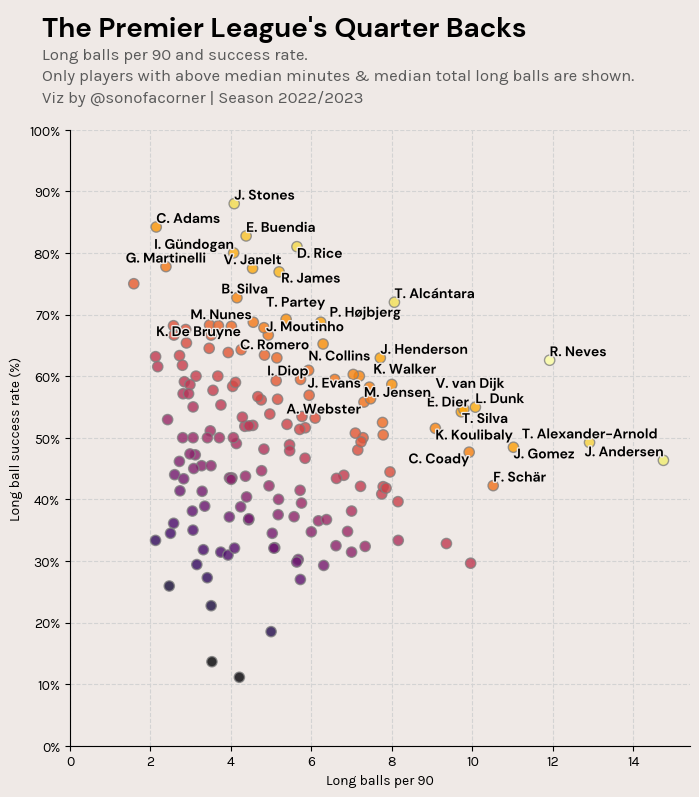

In [132]:
fig = plt.figure(figsize=(8,8), dpi=100)
ax = plt.subplot()
ax.grid(visible=True, ls='--', color='lightgrey')

ax.scatter(
    df_plot['per_90'], df_plot['succ_rate'], 
    c=df_plot['zscore'], cmap='inferno', 
    zorder=3, ec='grey', s=55, alpha=0.8)
    
texts = []
annotated_df = df_plot[df_plot['annotated']].reset_index(drop=True)
for index in range(annotated_df.shape[0]):
    texts += [
        ax.text(
            x=annotated_df['per_90'].iloc[index], y=annotated_df['succ_rate'].iloc[index],
            s=f"{annotated_df['player_first_name'].iloc[index][0]}. {annotated_df['player_last_name'].iloc[index]}",
            path_effects=[path_effects.Stroke(linewidth=2, foreground=fig.get_facecolor()), 
            path_effects.Normal()], color='black',
            family='DM Sans', weight='bold'
        )
    ]

adjust_text(texts, only_move={'points':'y', 'text':'xy', 'objects':'xy'})

ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(.1))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0%}'))
ax.set_xlim(0)
ax.set_ylim(0,1)

ax.set_ylabel('Long ball success rate (%)')
ax.set_xlabel('Long balls per 90')

fig_text(
    x = 0.09, y = .99, 
    s = "The Premier League's Quarter Backs",
    va = "bottom", ha = "left",
    fontsize = 20, color = "black", font = "DM Sans", weight = "bold"
)

fig_text(
    x = 0.09, y = 0.91, 
    s = "Long balls per 90 and success rate.\nOnly players with above median minutes & median total long balls are shown.\nViz by @sonofacorner | Season 2022/2023",
    va = "bottom", ha = "left",
    fontsize = 12, color = "#5A5A5A", font = "Karla"
)

plt.savefig(
	"figures/11072022_long_balls.png",
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)

plt.savefig(
	"figures/11072022_long_balls_tr.png",
	dpi = 600,
	facecolor = "none",
	bbox_inches="tight",
    edgecolor="none",
	transparent = True
)
